In [1]:
# Notebook to study the gammas emmited from the 2nubb events
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from matplotlib.colors import LogNorm  # Import LogNorm for logarithmic color scale
from matplotlib.cm import get_cmap

# Create a sequential colormap
cmap = get_cmap('viridis')  # You can choose any sequential colormap here

In [2]:
def inside_circle(r, R):
    if r <= R:
        return True  # Point is inside the circle
    else:
        return False  # Point is outside the circle

In [3]:
# Loading in the file
files = []

files.append("xesphere_singleeminus_10_bar_2.5_MeV.h5")
files.append("xesphere_bb_10_bar_2.5_MeV.h5")

print(files)

config_v = []
parts_v  = []
hits_v   = []
energy_v = []
pressure_v = []
 
 
for index, f in enumerate(files):
    config_v.append(pd.read_hdf("../data/nexus/10bar/" + f, 'config'))
    parts_v .append(pd.read_hdf("../data/nexus/10bar/" + f, 'parts'))
    hits_v  .append(pd.read_hdf("../data/nexus/10bar/" + f, 'hits'))

    eventtype = config_v[index][config_v[index]["param_key"] == "/nexus/RegisterGenerator"].iloc[0]['param_value']

    if (eventtype == "Decay0Interface"):
        eventtype = "bb"
        energy = "0nuBB"
        energy_v.append(energy)
    else:
        eventtype = "singleeminus"

        # Then also get the energy
        energy = config_v[index][ config_v[index]["param_key"] == "/Generator/SingleParticle/min_energy"].iloc[0]['param_value']
        energy = [float(num) if '.' in num else int(num) for num in energy.split() if num.replace('.', '', 1).isdigit()]
        energy_v.append(energy[0])
        print(energy[0])

    pressure = config_v[index][ config_v[index]["param_key"] == "/Geometry/XeSphere/pressure"].iloc[0]['param_value']
    pressure = [float(num) if '.' in num else int(num) for num in pressure.split() if num.replace('.', '', 1).isdigit()]
    pressure = f"{int(pressure[0])}_bar"
    pressure_v.append(pressure)

display(config_v[0])

['xesphere_singleeminus_10_bar_2.5_MeV.h5', 'xesphere_bb_10_bar_2.5_MeV.h5']
2.5


,param_key,param_value
0,event_type,background
1,num_events,5000
2,saved_events,5000
3,interacting_events,5000
4,/PhysicsList/RegisterPhysics,G4EmStandardPhysics_option4
5,/PhysicsList/RegisterPhysics,G4DecayPhysics
6,/PhysicsList/RegisterPhysics,G4RadioactiveDecayPhysics
7,/PhysicsList/RegisterPhysics,NexusPhysics
8,/PhysicsList/RegisterPhysics,G4StepLimiterPhysics
9,/nexus/RegisterGeometry,XeSphere


In [4]:
# Plot the distance of the gammas and bin in a histogram
gammas_v = []

for df in parts_v:
    gammas_v.append(df[df["particle_name"] == "gamma"])


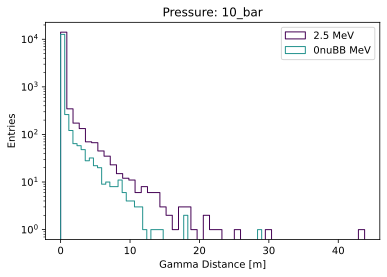

In [5]:
plt.figure()

dist_counts_v = []
dist_bins_v = []

pd.options.mode.chained_assignment = None  # Set it to "None" to disable the warning

for index, g in enumerate(gammas_v):
    deltax = g['final_x'] - g['initial_x']
    deltay = g['final_y'] - g['initial_y']
    deltaz = g['final_z'] - g['initial_z']

    # g['distances'] = np.sqrt(g['final_x']*g['final_x'] + g['final_y']*g['final_y'] + g['final_z']*g['final_z'])/1000
    g['distances'] =  np.sqrt( deltax**2 + deltay**2 + deltaz**2 )/1000
    g['inside'] = g['distances'].apply(lambda x: inside_circle(x, 15e-3))
    # print(distances)

    # bin_edges = np.linspace(0, g['distances'].max(), 50000);
    bin_edges = np.linspace(0, g['distances'].max(), 50);
    # bin_edges = np.linspace(0, 20, 10000);

    counts, bins, _ = plt.hist(g['distances'] , bins = bin_edges, histtype='step', label = f"{energy_v[index]} MeV", color=cmap(index/len(gammas_v)))

    dist_counts_v.append(counts)
    dist_bins_v.append(bins)

plt.xlabel("Gamma Distance [m]")
# plt.xlim(0, gammas_v[4].distances.max()) 
plt.ylabel("Entries")
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title(f"Pressure: {pressure_v[0]}")
plt.legend()

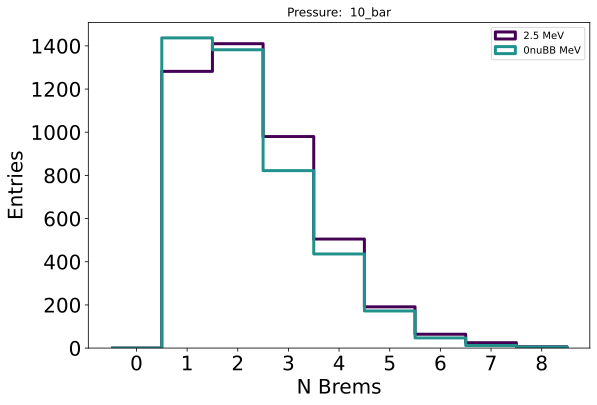

In [6]:
# Plt the bremstrahlung frequency per event
eBrems = []

for index, g in enumerate(gammas_v):
    eBrems.append(g[ g['creator_proc'] == "eBrem"])

bin_edges = np.arange(-0.5, 9.5, 1)
bin_centers = np.arange(0, 9, 1)


fig, ax1 = plt.subplots(figsize=(9,6))

for index, df in enumerate(eBrems):

    eventids = df.event_id.unique()

    n_photon_v = []

    for e in eventids:
        temp_df = df[ df["event_id"] == e]
        n_photon_v.append(len(temp_df))

    # plt.subplot(2, 3, index+1)
    ax1.hist(n_photon_v, bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth = 3)
    
    # Create a twin y-axis (ax2) for percentages
    # ax2 = ax1.twinx()

    # Calculate the histogram as percentages relative to 500
    # hist, bins = np.histogram(n_photon_v, bins=bin_edges)
    # percentages = hist * 100 / 5000  # Divide by 5 (500/100) to normalize to 500 total
    # ax2.plot(bins[:-1], percentages, linestyle='-', marker='o', color='white')

    ax1.set_xlabel("N Brems", fontsize=20)
    ax1.set_ylabel("Entries", fontsize=20)
    ax1.legend()
    ax1.set_xticks(bin_centers) 
    ax1.set_title( f"Pressure:  {pressure_v[0]}")
    ax1.tick_params(axis='both', labelsize=20)  # Adjust the tick label font size as needed
    
    # ax2.tick_params(axis='both', labelsize=20)  # Adjust the tick label font size as needed
    # ax2.set_ylabel('Fraction of events [%]', fontsize=20, labelpad=20)
    # ax2.set_ylim(0, 100*1400/5000)

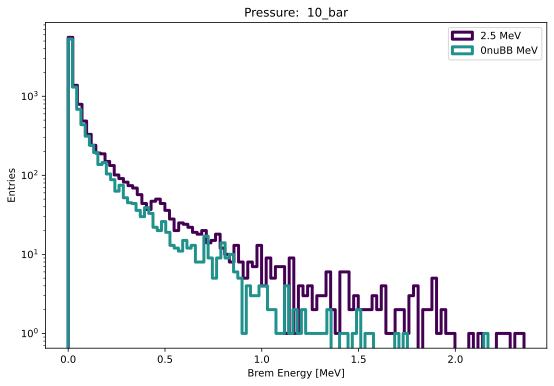

In [7]:
# Plot the gamma ray energy

plt.figure(figsize=(9,6))  # Adjust the figure size as needed

counts_v = []
bins_v = []


for index, df in enumerate(eBrems):

    n_photon_v = []
    bin_edges = np.linspace(0, df["kin_energy"].max(), 100);
    # bin_edges = np.linspace(0, 0.03, 100);
    counts, bins, _  = plt.hist(df["kin_energy"], bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth=3, log = True);
    counts_v.append(counts)
    bins_v.append(bins)

    plt.xlabel("Brem Energy [MeV]")
    plt.ylabel("Entries")
    plt.title( f"Pressure:  {pressure_v[0]}")
    plt.legend()

Number outside:  5372
Number inside:  9705
Number outside:  4354
Number inside:  9052


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,final_y,final_z,final_t,kin_energy,length,creator_proc,final_proc,distances,inside
5,0,2,gamma,0,1,-45.139835,107.164291,-57.300213,0.573879,-45.100239,107.661156,-57.462349,0.575627,0.012223,0.524147,eBrem,phot,0.000524,True
23,1,3,gamma,0,1,25.278801,-25.815496,-0.058908,0.129790,25.730560,-26.014095,-0.223503,0.131525,0.035829,0.520211,eBrem,phot,0.000520,True
33,1,15,gamma,0,3,25.730560,-26.014095,-0.223503,0.131525,25.726816,-26.018799,-0.216669,0.131555,0.004097,0.009103,phot,phot,0.000009,True
43,1,2,gamma,0,1,11.148777,-17.762598,0.154694,0.072749,11.348250,-18.207705,0.206897,0.074386,0.004015,0.490545,eBrem,phot,0.000491,True
50,2,10,gamma,0,9,-94.753578,38.433472,62.608009,0.934274,-94.755699,38.413963,62.610142,0.934340,0.002571,0.019740,eBrem,phot,0.000020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208270,4998,3,gamma,0,1,29.974270,33.180721,-53.408016,0.293137,64.999146,18.439199,-79.993454,0.447834,0.051228,46.377148,eBrem,phot,0.046377,False
208274,4998,38,gamma,0,3,64.999146,18.439199,-79.993454,0.447834,70.500671,26.341024,-81.102776,0.480163,0.034408,9.692072,phot,phot,0.009692,True
208287,4998,2,gamma,0,1,27.393290,34.458988,-51.278751,0.280925,27.956066,34.096249,-51.815678,0.283788,0.009780,0.858247,eBrem,phot,0.000858,True
208308,4999,6,gamma,0,1,24.642174,-83.363251,-69.299606,1.013767,23.230738,-86.367210,-69.324501,1.024838,0.018910,3.319117,eBrem,phot,0.003319,True


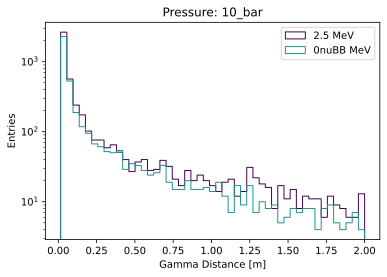

In [8]:
# Now lets study how many brems might be visible if we apply some binning and diffusion
# sipm pitch is 15 mm this is about larger than the diffusion expected at the center of the detector < 7 mm



plt.figure()
for index, g in enumerate(gammas_v):

    print("Number outside: ", len(g[g.inside == False]))
    print("Number inside: ", len(g[g.inside == True]))

    # bin_edges = np.linspace(0, g['distances'].max(), 50000);
    bin_edges = np.linspace(15e-3, 2, 50);
    # bin_edges = np.linspace(0, 20, 10000);

    counts, bins, _ = plt.hist( g[g.inside == False].distances , bins = bin_edges, histtype='step', label = f"{energy_v[index]} MeV", color=cmap(index/len(gammas_v)))

    dist_counts_v.append(counts)
    dist_bins_v.append(bins)

plt.xlabel("Gamma Distance [m]")
# plt.xlim(0, gammas_v[4].distances.max()) 
plt.ylabel("Entries")
plt.yscale('log')  # Set the y-axis to logarithmic scale
plt.title(f"Pressure: {pressure_v[0]}")
plt.legend()

display(gammas_v[0])

# Make the Gamma plot again with this cut




Number of events: 4463
4463
Number of events: 4313
4313


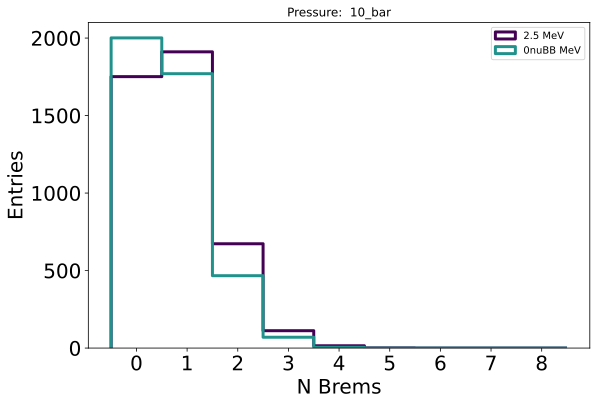

In [14]:
bin_edges = np.arange(-0.5, 9.5, 1)
bin_centers = np.arange(0, 9, 1)

fig, ax1 = plt.subplots(figsize=(9,6))

for index, df in enumerate(eBrems):

    eventids = df.event_id.unique()
    print("Number of events:",len(eventids) )

    n_photon_v = []

    for e in eventids:
        temp_df = df[ df["event_id"] == e]
        temp_df = temp_df[temp_df.inside == False]
    
        # if (len(temp_df) != 0):
        n_photon_v.append(len(temp_df))

    print(len(n_photon_v))

    # plt.subplot(2, 3, index+1)
    ax1.hist(n_photon_v, bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth = 3)
    
    # Create a twin y-axis (ax2) for percentages
    # ax2 = ax1.twinx()

    # Calculate the histogram as percentages relative to 500
    # hist, bins = np.histogram(n_photon_v, bins=bin_edges)
    # percentages = hist * 100 / 5000  # Divide by 5 (500/100) to normalize to 500 total
    # ax2.plot(bins[:-1], percentages, linestyle='-', marker='o', color='white')

    ax1.set_xlabel("N Brems", fontsize=20)
    ax1.set_ylabel("Entries", fontsize=20)
    ax1.legend()
    ax1.set_xticks(bin_centers) 
    ax1.set_title( f"Pressure:  {pressure_v[0]}")
    ax1.tick_params(axis='both', labelsize=20)  # Adjust the tick label font size as needed


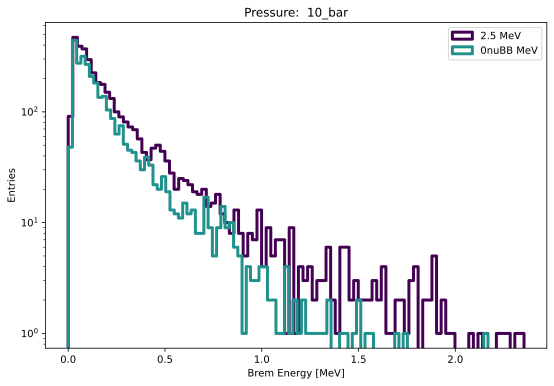

In [18]:
# Plot the gamma ray energy

plt.figure(figsize=(9,6))  # Adjust the figure size as needed

counts_v = []
bins_v = []


for index, df in enumerate(eBrems):

    n_photon_v = []
    bin_edges = np.linspace(0, df[df.inside == False].kin_energy.max(), 100);
    # bin_edges = np.linspace(0, 0.03, 100);
    counts, bins, _  = plt.hist(df[df.inside == False].kin_energy, bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth=3, log = True);
    # counts, bins, _  = plt.hist(df[df.inside == True].kin_energy, bins = bin_edges, label = f"{energy_v[index]} MeV", color=cmap(index/len(eBrems)), histtype="step", linewidth=3, log = True);
    counts_v.append(counts)
    bins_v.append(bins)

    plt.xlabel("Brem Energy [MeV]")
    plt.ylabel("Entries")
    plt.title( f"Pressure:  {pressure_v[0]}")
    plt.legend()